# Tabular Playground Series

## Data description
The dataset is used for this competition is synthetic, but based on a real dataset and generated using a CTGAN. The original dataset deals with predicting the category on an eCommerce product given various attributes about the listing. Although the features are anonymized, they have properties relating to real-world features.

## Files
* train.csv - the training data, one product (id) per row, with the associated features (feature_*) and class label (target)
* test.csv - the test data; you must predict the probability the id belongs to each class
* sample_submission.csv - a sample submission file in the correct format

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

We have 50 features, 52 columns and 100000 entries for the train dataset, and also we dont have null fields, so the dataset is almost clean.

In [2]:
data_train = pd.read_csv('train.csv')

In [3]:
data_train.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,3,0,0,21,0,0,0,0,0,0,Class_2
1,1,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_1
2,2,0,0,0,0,0,0,0,0,0,2,0,0,1,0,1,0,0,0,0,1,0,5,2,1,1,0,1,0,2,0,0,0,0,19,2,0,1,7,3,0,0,0,1,0,0,0,0,13,2,0,Class_1
3,3,0,0,0,0,0,0,0,3,0,0,0,0,0,1,7,11,1,0,3,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,4,0,0,0,0,0,0,0,0,0,1,0,Class_4
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,9,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,Class_2


In [4]:
# Droping id col
data_train = data_train.drop('id', axis=1)

In [5]:
# Features descriptive analysis.
data_train.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='RdPu')\
                            .background_gradient(subset=['max'], cmap='BuPu')

,count,mean,std,min,25%,50%,75%,max
feature_0,100000.000000,0.257830,0.929033,0.000000,0.000000,0.000000,0.000000,10.000000
feature_1,100000.000000,0.431720,1.977862,0.000000,0.000000,0.000000,0.000000,31.000000
feature_2,100000.000000,0.114130,0.519584,0.000000,0.000000,0.000000,0.000000,6.000000
feature_3,100000.000000,0.590550,1.844558,0.000000,0.000000,0.000000,0.000000,26.000000
feature_4,100000.000000,0.599770,2.785531,0.000000,0.000000,0.000000,0.000000,38.000000
feature_5,100000.000000,0.160820,0.601149,0.000000,0.000000,0.000000,0.000000,10.000000
feature_6,100000.000000,0.731490,2.343465,0.000000,0.000000,0.000000,0.000000,27.000000
feature_7,100000.000000,1.228920,2.692732,0.000000,0.000000,0.000000,1.000000,31.000000
feature_8,100000.000000,0.903350,3.415258,0.000000,0.000000,0.000000,0.000000,39.000000
feature_9,100000.000000,0.940120,1.904172,0.000000,0.000000,0.000000,1.000000,17.000000


In [6]:
# Target distribution
target_counter = data_train.target.value_counts(sort=True, ascending=False)

fig = go.Figure([go.Bar(x=target_counter.index, y=target_counter.values, marker_color='crimson')])
fig.show()

In [26]:
# Target column clasess into numbers

label_dict = {val:idx for idx, val in enumerate(sorted(data_train['target'].unique()))}
data_train['target'] = data_train['target'].map(label_dict)

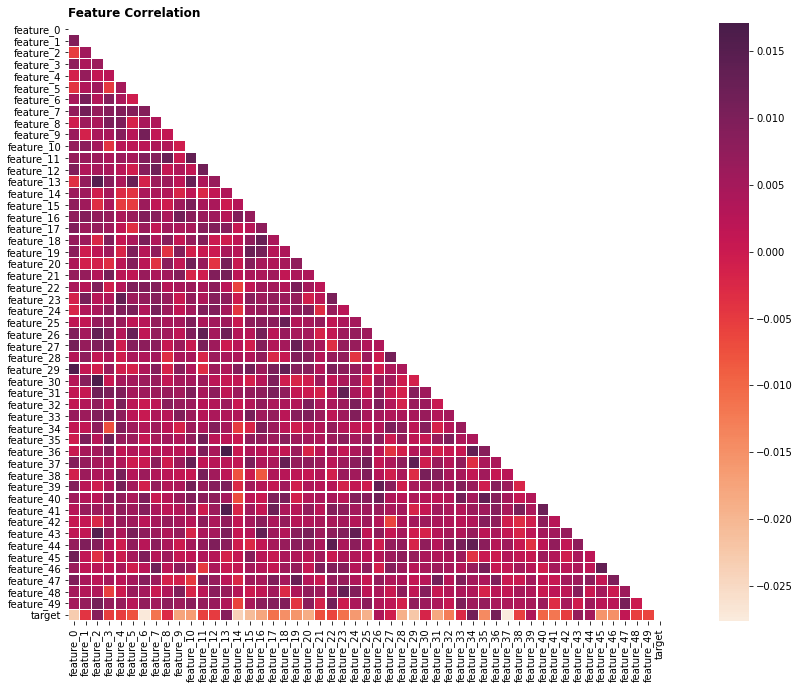

In [27]:
# Scatterplot matrix

fig, ax = plt.subplots(figsize=(19, 11))

corr = data_train.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,
        square = True, center=0, linewidth=0.2,
        cmap = sns.color_palette("rocket_r", as_cmap=True),
        mask = mask, ax = ax) 

ax.set_title('Feature Correlation', loc='left', fontweight='bold')
plt.show()

The correlation between all the collumns seems to be less than 0.02

## Feature Scaling 

In [ ]:
"""from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(data_train)
X_test = sc.transform(X_test)"""

## Dimension reduction

In [24]:
! pip install umap-learn

     |████████████████████████████████| 81kB 3.3MB/s 
     |████████████████████████████████| 1.2MB 7.4MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=9e423bfbdfd41a979959ef6263496f14883cda292458da4108b54f150deaff6e
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=8e0902d93c58ba8362c4c9a3513363e5e23c06c1cc9fcf48d483fbe89b53c3c0
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


In [41]:
def r_dim_plot(dr):
  
  raw_dark_palette = [
    (10, 132, 255), # Blue
    (255, 159, 10), # Orange
    (48, 209, 88),  # Green
    (255, 69, 58),  # Red
    (191, 90, 242), # Purple
    (94, 92, 230),  # Indigo
    (255, 55, 95),  # Pink
    (100, 210, 255),# Teal
    (255, 214, 10)  # Yellow
    ]
  raw_gray_light_palette = [
    (142, 142, 147),# Gray
    (174, 174, 178),# Gray (2)
    (199, 199, 204),# Gray (3)
    (209, 209, 214),# Gray (4)
    (229, 229, 234),# Gray (5)
    (242, 242, 247),# Gray (6)
    ]

  dark_palette = np.array(raw_dark_palette)/255
  gray_light_palette = np.array(raw_gray_light_palette)/255

  white_color = gray_light_palette[-2]

  fig = plt.figure(figsize=(12, 12))
  gs = fig.add_gridspec(5, 4)
  ax = fig.add_subplot(gs[:-1,:])

  sub_axes = [None] * 4
  for idx in range(4): 
      sub_axes[idx] = fig.add_subplot(gs[-1,idx])

  for idx in range(4):
      ax.scatter(x=dr[:,0][target==idx], y=dr[:,1][target==idx],
                s=10, alpha=0.2
                )

      for j in range(4):
          sub_axes[j].scatter(x=dr[:,0][target==idx], y=dr[:,1][target==idx],
                                s=10, alpha = 0.4 if idx==j else 0.008, color = (dark_palette[j%9]) if idx==j else white_color,
                              zorder=(idx==j)
                            )
          
      
      sub_axes[idx].set_xticks([])
      sub_axes[idx].set_yticks([])
      sub_axes[idx].set_xlabel('')
      sub_axes[idx].set_ylabel('')
      sub_axes[idx].set_title(f'Class_{idx+1}')
      sub_axes[idx].spines['right'].set_visible(True)
      sub_axes[idx].spines['top'].set_visible(True)

  ax.set_title('Dimenstion Reduction (UMAP)', fontweight='bold', fontfamily='serif', fontsize=20, loc='left')   
      
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)

  fig.tight_layout()
  plt.show()

In [28]:
from umap import UMAP

train = data_train

train_sub = train.sample(20000, random_state=0)
target = train_sub['target']
umap = UMAP(random_state=0)
dr = umap.fit_transform(train_sub.iloc[:,:-1], target)

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

target = train_sub['target']

lda = LDA(n_components=2)
X_train = lda.fit_transform(train_sub.iloc[:,:-1], target)
#X_test = lda.transform(X_test)

In [8]:
# https://www.kaggle.com/subinium/tps-may-categorical-eda

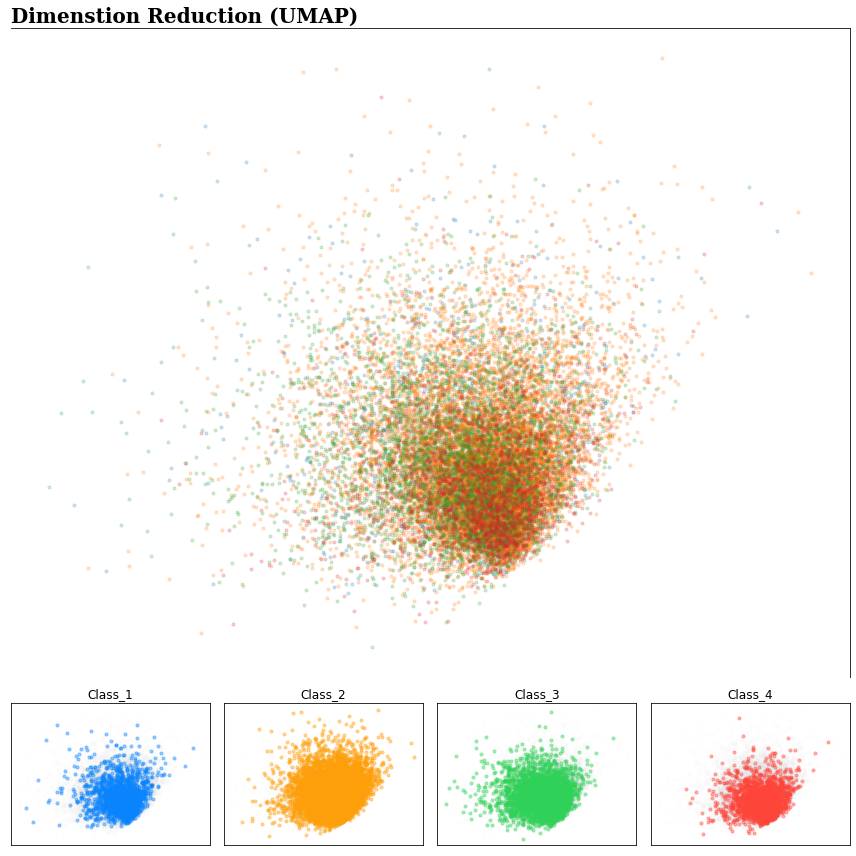

In [42]:
r_dim_plot(X_train)

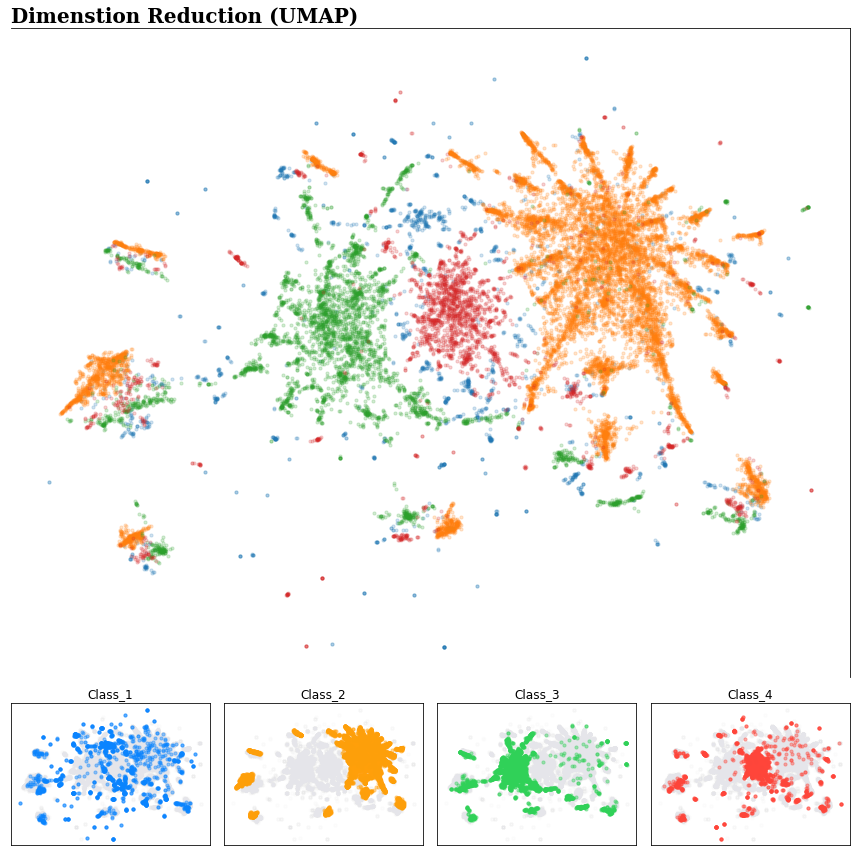

In [43]:
r_dim_plot(dr)